<a href="https://www.kaggle.com/code/marinabalakina/dll30-dz4-1?scriptVersionId=155040270" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
# ** Домашнее** задание по теме «Архитектуры свёрточных сетей»

Цель задания: изучить работу с готовыми моделями из torchvision.

Контекст

Вам необходимо подобрать базовую модель для работы по вашей задаче. Вы пробуете обучать различные модели на “ваших” данных. По результатам отберёте лучшую для дальнейшего обучения.

Задание

Вам необходимо провести эксперименты по начальному обучению различных моделей и сравнить результаты.

1.Возьмите датасет EMNIST из torchvision

2. Обучите на нём модели: ResNet 18, VGG 16, Inception v3, DenseNet 161 (с нуля по 10 эпох)

3. Сведите результаты обучения моделей (графики лоса) в таблицу и сравните их.


Задание со звездочкой*

* Выполните то же задание, используя датасет hymenoptera_data

Инструкция к выполнению задания

* Загрузите датасет, посмотрите примеры картинок в нём и проверьте наличествующие классы и их дисбаланс.

* Создайте модель текущего типа, используя интерфейс torchvision для нужного количества классов.

* Обучите модель с нуля 10 эпох. Фиксируйте значение функции потерь в список для последующего отображения.

Повторите пункты 2 и 3 для всех указанных вариантов моделей.

Формат сдачи работы

Прикрепите ссылку на готовое решение в личном кабинете. Работу можно отправлять в виде ссылки на python-ноутбук из GitHub, Google Colaboratory или аналогичных платформ. Не забудьте открыть доступ на просмотр и комментирование.

Критерии оценивания
По итогу выполнения задания вы получите зачёт.

Задание считается выполненным, если:

вы обучили каждую модель до некоторого улучшения качества

составлена таблица обучения для сравнения

Задание будет отправлено на доработку, если:

использованы не все типы моделей

не составлена сводная таблица с результатами

# Импорт библиотек и пользовательские функции

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

In [23]:
import torch
from torch import nn
import torchvision as tv # consists of popular datasets, model architectures, and common image transformations for computer vision - для работы с предобученными нейросетями
import time

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [25]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0, 0
    net.eval()
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [26]:
def train(net, train_iter, test_iter, trainer, num_epochs):
    net.to(device)
    loss = nn.CrossEntropyLoss(reduction='sum')
    net.train()
    train_accuracy, train_losses, test_accuracy =[], [], []
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()

        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]

            if i % 10 == 0:
              print(f"Step {i}. time since epoch: {time.time() -  start:.3f}. "
                    f"Train acc: {train_acc_sum / n:.3f}. Train Loss: {train_l_sum / n:.3f}")
        test_acc = evaluate_accuracy(test_iter, net.to(device))
        print('-' * 20)
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}'
              f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')
        train_accuracy.append(train_acc_sum / n)
        train_losses.append(train_l_sum / n)
        test_accuracy.append(test_acc)
    return train_accuracy, train_losses, test_accuracy

In [27]:
BATCH_SIZE = 256
# Переводим картинки в 224х224 и в тензор
transoforms = tv.transforms.Compose([

    tv.transforms.Resize((224, 224)),
    tv.transforms.ToTensor()
])
train_dataset = tv.datasets.EMNIST('.', split='mnist', train=True, transform=transoforms, download=True)
test_dataset = tv.datasets.EMNIST('.', split='mnist', train=False, transform=transoforms, download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

## 1.1. Визуализация

In [28]:
train_dataset.classes

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

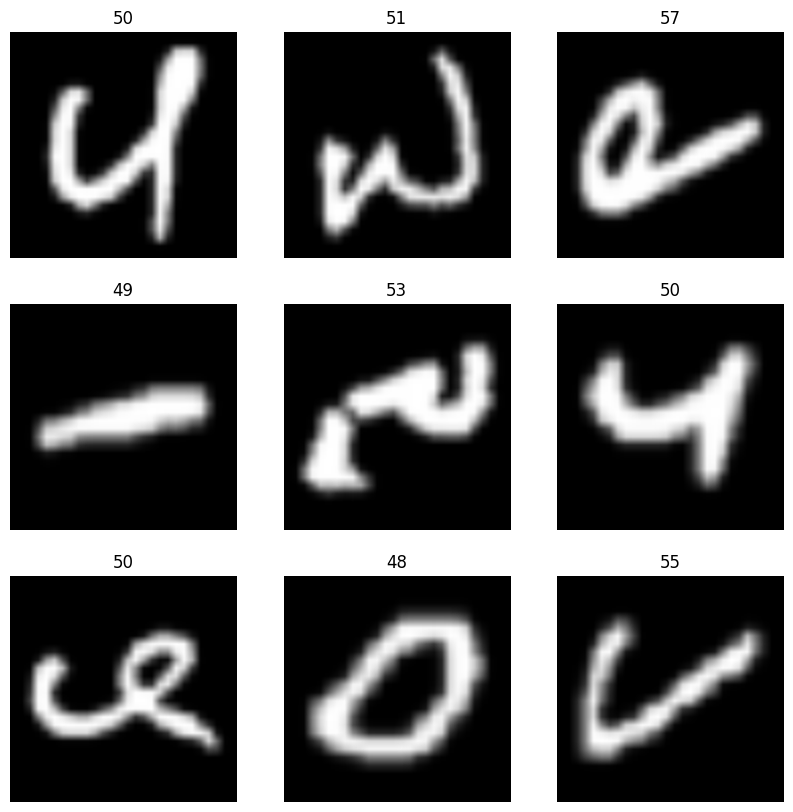

In [29]:
labels_map={
    0: '48',
    1: '49',
    2: '50',
    3: '51',
    4: '52',
    5: '53',
    6: '54',
    7: '55',
    8: '56',
    9: '57',
}

figure = plt.figure(figsize = (10,10))
cols, rows = 3, 3

for i in range (1, cols*rows + 1):
    sample_idx = torch.randint(len(train_dataset), size = (1,)).item()
    image, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
plt.show()

In [30]:
# считаем количество элементов
targets = train_dataset.targets
counts = torch.bincount(targets)
for i, count in enumerate(counts):
    print(f"{i}: {count}")

0: 6000
1: 6000
2: 6000
3: 6000
4: 6000
5: 6000
6: 6000
7: 6000
8: 6000
9: 6000


Классы сбалансированы

# 2. Обучение моделей

## 2.1. ResNET 18

In [31]:
classification_models = tv.models.list_models(module=tv.models)

In [32]:
classification_models

['alexnet',
 'convnext_base',
 'convnext_large',
 'convnext_small',
 'convnext_tiny',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_v2_l',
 'efficientnet_v2_m',
 'efficientnet_v2_s',
 'googlenet',
 'inception_v3',
 'maxvit_t',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'regnet_x_16gf',
 'regnet_x_1_6gf',
 'regnet_x_32gf',
 'regnet_x_3_2gf',
 'regnet_x_400mf',
 'regnet_x_800mf',
 'regnet_x_8gf',
 'regnet_y_128gf',
 'regnet_y_16gf',
 'regnet_y_1_6gf',
 'regnet_y_32gf',
 'regnet_y_3_2gf',
 'regnet_y_400mf',
 'regnet_y_800mf',
 'regnet_y_8gf',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext101_64x4d',
 'resnext50_32x4d',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'sh

In [33]:
# Если брать предобученные модели из torchvision.models, то они обучены на изображениях (224,224,3). Поэтому на до перетрансформировать датасеты 
transoforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((224, 224)),
    tv.transforms.ToTensor()
])

train_dataset = tv.datasets.MNIST('.', train=True, transform=transoforms, download=True)
test_dataset = tv.datasets.MNIST('.', train=False, transform=transoforms, download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [34]:
model = tv.models.resnet18(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [35]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [36]:
# Убираем требование градиента:
for param in model.parameters():
    param.requires_grad = False

In [37]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [38]:
model.fc = nn.Linear(in_features=512, out_features=10)

In [39]:
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 fc.weight
	 fc.bias


In [40]:
trainer = torch.optim.Adam(params_to_update, lr=0.001)

In [41]:
train_accuracy, train_losses, test_accuracy = train(model, train_iter, test_iter, trainer, 10)

Step 0. time since epoch: 0.514. Train acc: 0.059. Train Loss: 2.485
Step 10. time since epoch: 5.204. Train acc: 0.306. Train Loss: 2.054
Step 20. time since epoch: 9.744. Train acc: 0.492. Train Loss: 1.785
Step 30. time since epoch: 14.236. Train acc: 0.586. Train Loss: 1.585
Step 40. time since epoch: 18.711. Train acc: 0.646. Train Loss: 1.427
Step 50. time since epoch: 23.288. Train acc: 0.690. Train Loss: 1.298
Step 60. time since epoch: 27.716. Train acc: 0.721. Train Loss: 1.195
Step 70. time since epoch: 32.299. Train acc: 0.744. Train Loss: 1.111
Step 80. time since epoch: 36.695. Train acc: 0.764. Train Loss: 1.037
Step 90. time since epoch: 41.208. Train acc: 0.779. Train Loss: 0.975
Step 100. time since epoch: 45.647. Train acc: 0.792. Train Loss: 0.923
Step 110. time since epoch: 50.056. Train acc: 0.802. Train Loss: 0.880
Step 120. time since epoch: 54.648. Train acc: 0.810. Train Loss: 0.844
Step 130. time since epoch: 59.101. Train acc: 0.817. Train Loss: 0.811
Step 1

In [42]:
df_results= pd.DataFrame(columns = ['model', 'train_accuracy', 'train_loss', 'test_accuracy','epoch'])
for i in range(10):
  df_results.loc[len(df_results.index)] = ['resnet18',  train_accuracy[i], train_losses[i], test_accuracy[i], i]

In [43]:
df_results

,model,train_accuracy,train_loss,test_accuracy,epoch
0,resnet18,0.866567,0.590512,0.9369,0
1,resnet18,0.944000,0.221177,0.9491,1
2,resnet18,0.953667,0.170367,0.9555,2
3,resnet18,0.958917,0.146143,0.9576,3
4,resnet18,0.962167,0.131354,0.9593,4
5,resnet18,0.964850,0.121129,0.9604,5
6,resnet18,0.966867,0.113501,0.9615,6
7,resnet18,0.967950,0.107511,0.9622,7
8,resnet18,0.969550,0.102632,0.9621,8
9,resnet18,0.970550,0.098548,0.9629,9


In [44]:
df_results.to_csv('resnet.csv', index=False)

## 2.2. VGG16

In [ ]:
torch.cuda.empty_cache()

In [ ]:
BATCH_SIZE = 256
# Переводим картинки в 224х224 и в тензор
transoforms = tv.transforms.Compose([

    tv.transforms.Resize((224, 224)),
    tv.transforms.ToTensor()
])
train_dataset = tv.datasets.EMNIST('.', split='mnist', train=True, transform=transoforms, download=True)
test_dataset = tv.datasets.EMNIST('.', split='mnist', train=False, transform=transoforms, download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
def vgg_block(num_convs, input_channels, num_channels):
    blk = nn.Sequential(nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1), nn.ReLU())
    for i in range(num_convs - 1):
        blk.add_module("conv{}".format(i), nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1))
        blk.add_module("relu{}".format(i), nn.ReLU())
    blk.add_module("pool", nn.MaxPool2d(2, stride=2))
    return blk

In [ ]:
def vgg(conv_arch):
    net = nn.Sequential()

    for i, (num_convs, input_ch, num_channels) in enumerate(conv_arch):
        net.add_module("block{}".format(i), vgg_block(num_convs, input_ch, num_channels))


    classifier = nn.Sequential(
        nn.Flatten(),

        # nn.Linear(25088, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(6272, 4096), nn.ReLU(), nn.Dropout(0.5),

        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10))

    net.add_module('classifier', classifier)
    return net

In [ ]:
conv_arch = ((1, 1, 64), (1, 64, 128), (2, 128, 256), (2, 256, 512), (2, 512, 512))

In [ ]:
ratio = 4
small_conv_arch = [(v[0], max(v[1] // ratio, 1), v[2] // ratio) for v in conv_arch]
net = vgg(small_conv_arch)

In [ ]:
lr, num_epochs = 0.001, 10
trainer = torch.optim.Adam(net.parameters(), lr=lr)

In [ ]:
train_accuracy, train_losses, test_accuracy  = train(net, train_iter, test_iter, trainer, num_epochs)

In [ ]:
df_results= pd.DataFrame(columns = ['model', 'train_accuracy', 'train_loss', 'test_accuracy','epoch'])
for i in range(10):
  df_results.loc[len(df_results.index)] = ['vgg16',  train_accuracy[i], train_losses[i], test_accuracy[i], i]

In [ ]:
df_results

## 2.3. Inception v3

In [ ]:
torch.cuda.empty_cache()
model = tv.models.inception_v3(pretrained=True)

In [ ]:
model

In [ ]:
# Убираем требование градиента:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

In [ ]:
lr, num_epochs = 0.001, 1
trainer = torch.optim.Adam(params_to_update, lr=lr)
train_accuracy, train_losses, test_accuracy  = train(model, train_iter, test_iter, trainer, num_epochs)

In [ ]:
for i in range(10):
  df_results.loc[len(df_results.index)] = ['inception_v3',  train_accuracy[i], train_losses[i], test_accuracy[i], i]

## 2.4. DenseNet 161

In [ ]:
torch.cuda.empty_cache()

In [ ]:
model = tv.models.densenet161(pretrained=True)

In [ ]:
model

In [ ]:
# Убираем требование градиента:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
model.classifier

In [ ]:
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

In [ ]:
trainer = torch.optim.Adam(params_to_update, lr=0.001)
train_accuracy, train_losses, test_accuracy  = train(model, train_iter, test_iter, trainer, num_epochs)

In [ ]:
for i in range(10):
  df_results.loc[len(df_results.index)] = ['densenet161',  train_accuracy[i], train_losses[i], test_accuracy[i], i]